# EELS SFO Project - Autoencoder

**Description about data**

Total of 90,000 spectra was provided: 
- 2 sets of 10 spectrum images with 300 x 30 spatial coordinates.
- Each spatial coordinate has 3710 energy channels. 
- For each spectra, the initial energy-loss value is 387.5 eV with energy width of 0.125 eV i.e. [387.5 : 851.25 : 0.125].

> initial state (SrFeO3 with Fe4+) 

> annealed state (SrFeO2.5 with Fe3+)

These two sets are provided to train an ML model. The goal is that this model will take any spectral data (single spectrum with very small number of signal counts) and spit out the corresponding oxidation states (4+/3+). So one way to test this is by sampling from the 90,000 spectral data to be predicted and cross validate. The question can be: (1) what is the lowest number of spectra needed before the model can no longer distinguish, (2) what is the fastest scan speed, (3) resistant to noise, ... and so on with the same idea.

* This would be considered supervised learning. But what Josh is doing is to see how the spectra changes over the image (in their spatial distribution). ML will tells you the statistical relationship/distribution within the image.


**Meeting with Mitra (10/17/19)** 

Josh has similar projects before that can be utilized
- Autoencoder: learning from low dimensional layers and recreate the image
- Reccurrence: eacch neuron evaluate timestep and passes the data into the cycle
- Utilize LSTM to the RNN
- Strong L1 regularization to impose sparsity to that layer

Recommendations:
- PCA doesn't look helpful. May need to use CNN.
- Pre-filtering will require trials and errors.
- Gaussian regression + sample on region of interest over 100 points 
- Difficulty is going to be on the preprocessing of the data
- Transformer network --> 1D convolution NN with attention has now replaced LSTM, rigorously proved that Attention is much more superior.

Data Collection Process:
- Fourier Transform (FFT) not done so much with EELS. 
- FFT Find the high frequency to pull out. But, in practice, we did not find FFT to be helpful.


## Some resources to read on Autoencoder

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hyperspy.api as hs
hs.preferences.GUIs.warn_if_guis_are_missing = False
import scipy
import seaborn as sns

In [3]:
'''
loading initial data
'''
data_initial = hs.load('High-Speed-EELS/High-Speed EELS/Initial SIs/*.dm4', signal_type="EELS", stack=False)
#print(data_initial[0].metadata)
#print(data_initial[0].axes_manager)

In [4]:
'''
loading annealed data
'''
data_anneal = hs.load('High-Speed-EELS/High-Speed EELS/annealed SIs/*.dm4', signal_type="EELS", stack=False)
#print(data_anneal[0].metadata)
#print(data_anneal[0].axes_manager)

In [5]:
'''
setting x-axis label
'''
for spectra in data_initial:
    corrected_xaxis = np.array([0.125*j+387.5 for j in range(spectra.data.shape[2])])
    print(len(corrected_xaxis), corrected_xaxis)
    break

3710 [387.5   387.625 387.75  ... 850.875 851.    851.125]


In [6]:
'''
Adding dark references to spectra
'''
def add_dark_ref(data, dark_ref):
    for k, spectra in enumerate(data):
        y = len(spectra.data)
        x = len(spectra.data[0])
        data[k].corrected = np.float32(np.copy(spectra.data))
        for i in range(y):
            for j in range(x):
                data[k].corrected[i][j] = np.sum([spectra.data[i][j],dark_ref.data], axis=0)
        #print("Completed "+str(k))
    print("Completed")

In [7]:
dark_ref = hs.load('High-Speed-EELS/High-Speed EELS/dark reference.dm4', signal_type="EELS")
print("Shape of dark ref spectra: " + str(dark_ref.data.shape))

add_dark_ref(data_initial, dark_ref)
add_dark_ref(data_anneal, dark_ref)

Shape of dark ref spectra: (3710,)
Completed
Completed


**Background Subtraction based on power law fit**

> Fit the equation "I = A*E^r"
    * I is the measured intensity, 
    * A is a constant
    * E is the energy-loss value (eV)
    * r is an exponent (usually around 3)
Select an energy window (around 50 eV wide), a few eV before the edge of interest to fit A and r

In [8]:
'''
Background Subtraction & Filter noise (Savizky-Golay Filter)

https://github.com/trygvrad/RNN-on-EELS-data/blob/master/EELScodes
https://scipy-cookbook.readthedocs.io/items/FittingData.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
'''
import scipy.optimize # curve_fit
from scipy.fftpack import fft
from dask import delayed 
#TODO: Look into using dask delayed to parallelize process or use multiprocessing function 
# https://stackoverflow.com/questions/25888255/how-to-use-python-multiprocessing-pool-map-to-fill-numpy-array-in-a-for-loop/25891939#25891939


def scaledExp(x,a,b):
    return a*np.exp((np.array(x))*b)

def subtractExpBackground(data1,xrange=None):
    data2 = np.float32(np.copy(data1))
    x = range(data1.shape[2])
    # fit over the entire spectra by default
    if type(xrange) == type(None):
        xrange = x 
    for i in range(data1.shape[0]):
        for j in range(data1.shape[1]):
            popt, pcov = scipy.optimize.curve_fit(scaledExp,xrange,data2[i,j,xrange], p0 = [4.19082741e+02, -1.93625569e-03])
            data2[i,j] = data2[i,j]-scaledExp(x,popt[0],popt[1])
            # print(popt)
    return data2

def subtract_bckgrnd_and_filter(data):
    backgroundregion = np.arange(400,1000,1)  # this is approximately 50eV wide, over the region before ROI
    for k,spectra in enumerate(data): 
        data[k].adjusted = subtractExpBackground(spectra.corrected,backgroundregion)
        data[k].SG_filter = scipy.signal.savgol_filter(data[k].adjusted, 51, 3) # window size 50, polynomial order 3

In [9]:
ps1 = subtract_bckgrnd_and_filter(data_initial)
ps2 = subtract_bckgrnd_and_filter(data_anneal)

In [16]:
'''
Downsampling the image 
https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.downscale_local_mean
'''
def downsample(data, N):
    from scipy.signal import resample
    
    for k,sp in enumerate(data):
        data[k].resample = np.zeros((sp.SG_filter.shape[0],sp.SG_filter.shape[1], N))
        for i in range(sp.SG_filter.shape[0]):
            for j in range(sp.SG_filter.shape[1]):
                data[k].resample[i][j] = resample(sp.SG_filter[i][j][:], N)      


In [17]:
N = 3710  # number of samples in the resampled set

downsample(data_initial, N)
downsample(data_anneal, N)

In [18]:
data_initial[0].resample.shape

(30, 300, 3710)

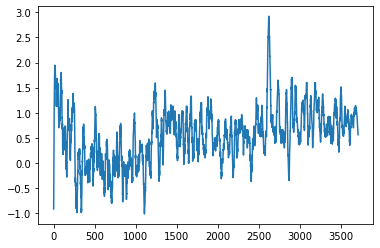

In [19]:
plt.plot(data_anneal[4].resample[20][20])

In [20]:
'''
Cutting region of interest to be analyzed
-----------------------

anly_range = 400 raw data points
O_range = starts @ 1100 [1100:1500]
Fe_range = starts @ 2500 [2500:2900]

'''
def cut_ROI(data, N, anly_range):
    import math
    N_0 = data[0].data.shape[2]
    N_1 = N  # number resampled (have to match previous resampling rate)

    for k,spectra in enumerate(data):
        data[k].O_range = np.zeros((spectra.resample.shape[0],spectra.resample.shape[1], anly_range))
        data[k].Fe_range = np.zeros((spectra.resample.shape[0],spectra.resample.shape[1], anly_range))
        for i in range(spectra.resample.shape[0]):
            for j in range(spectra.resample.shape[1]):
                data[k].O_range[i][j] = spectra.resample[i][j][math.ceil(1100/N_0*N_1):math.ceil(1100/N_0*N_1)+anly_range]
                data[k].Fe_range[i][j] = spectra.resample[i][j][math.ceil(2500/N_0*N_1):math.ceil(2500/N_0*N_1)+anly_range]

In [31]:
cut_ROI(data_initial, N, anly_range=128)
cut_ROI(data_anneal, N, anly_range=128)

In [32]:
data_collected = []

for data in data_initial:
    print(data.O_range)
    data_collected.append(np.asarray(data.O_range.reshape(-1,128)))
k = np.asarray(data_collected).reshape(-1,128)

[[[-2.58726236e-01 -3.00499346e-01 -2.86257602e-01 ...  4.74696283e-03
   -4.05906339e-02 -8.70596233e-02]
  [-2.85362067e-01 -3.27496740e-01 -3.27115631e-01 ...  1.09685077e+00
    1.08051528e+00  9.44835920e-01]
  [ 7.21598247e-01  6.62539346e-01  7.43370156e-01 ...  1.42036135e+00
    1.37357408e+00  1.34651691e+00]
  ...
  [ 5.78985816e-01  5.50869060e-01  4.42773594e-01 ...  1.87656761e+00
    1.84942806e+00  1.64117658e+00]
  [ 8.86978397e-02  1.05970057e-01  1.55451618e-01 ...  1.48386230e+00
    1.45139219e+00  1.44227661e+00]
  [-2.43994275e-01 -2.21051759e-01 -2.37203739e-01 ...  9.14495218e-01
    9.19513809e-01  8.41791737e-01]]

 [[ 2.43265898e-01  2.83540177e-01  2.21275659e-01 ...  6.28338725e-01
    6.97158723e-01  6.75423533e-01]
  [ 1.98200927e-01  7.31591140e-02  1.54871421e-01 ...  1.88796574e+00
    1.85301215e+00  1.83586306e+00]
  [ 7.21039595e-01  5.95940534e-01  6.29984323e-01 ...  1.31943105e+00
    1.18672680e+00  1.18707345e+00]
  ...
  [ 4.73042349e-01  5.5

In [33]:
k.shape

(90000, 128)

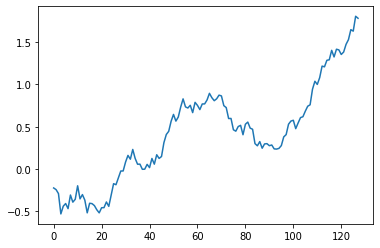

In [34]:
plt.plot(k[5000][:])

In [35]:
data_initial[0].O_range.shape

(30, 300, 128)

## Autoencoder (Keras)
- reconstructing 30x300 image 

Essentially, I'm trying to train an encoder and decoder

### Procedure
1. train
2. test

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

In [37]:
def rnn_auto(layer, size, num_encode_layers, num_decode_layers, embedding, n_step, lr = 3e-6, drop_frac=0.,bidirectional=False, l1_norm = 1e-4,**kwargs):
    """
    Function which builds the reccurrent neural network autoencoder
    Parameters
    ----------
    layer : string; options: 'lstm','gru'
        selects the layer type
    size  : numpy, int
        sets the size of encoding and decoding layers in the network
    num_encode_layers  : numpy, int
        sets the number of encoding layers in the network
    num_decode_layers : numpy, int
        sets the number of decoding layers in the network
    embedding : numpy, int
        sets the size of the embedding layer
    n_steps : numpy, int
        length of the input time series
    lr : numpy, float
        sets the learning rate for the model
    drop_frac : numpy, float
        sets the dropout fraction
    bidirectional : numpy, bool
        selects if the model is linear or bidirectional
    l1_norm : numpy. float
        sets the lambda value of the l1 normalization. The larger the value the greater the
        sparsity. None can be passed to exclude the use or l1 normailzation.
    Returns
    -------
    model : Keras, object
        Keras tensorflow model
    """

    # defines the model
    model = Sequential()

    # selects if the model is bidirectional
    if bidirectional:
        wrapper = Bidirectional
        # builds the first layer
        model.add(Bidirectional(layer(size, return_sequences=(num_encode_layers > 1),  dropout=drop_frac),
                            input_shape=(n_step, 1)))
    else:
        wrapper = lambda x: x
        # builds the first layer
        model.add(wrapper(layer(size, return_sequences=(num_encode_layers > 1),  dropout=drop_frac,
                input_shape=(n_step, 1))))

    # builds the encoding layers
    for i in range(1, num_encode_layers):
        model.add(wrapper(layer(size, return_sequences=(i < num_encode_layers - 1), dropout=drop_frac)))

    # builds the embedding layer
    if l1_norm == None:
        # embedding layer without l1 regulariization
        model.add(Dense(embedding, activation='relu', name='encoding'))
    else:
        # embedding layer with l1 regularization
        model.add(Dense(embedding, activation='relu', name='encoding',activity_regularizer=l1(l1_norm)))

    # builds the repeat vector
    model.add(RepeatVector(n_step))

    # builds the decoding layer
    for i in range(num_decode_layers):
        model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

    # builds the time distributed layer to reconstruct the original input
    model.add(TimeDistributed(Dense(1, activation='linear')))

    # complies the model
    model.compile(Adam(lr), loss='mse')

    # returns the model
    return model

def train_model(model, data_train, data_test, path, epochs, batch_size):
    """
    Function which trains the neural network
    Parameters
    ----------
    model : Keras, object
        model to train
    data_train  : numpy, float
        data to train the network
    data_test  : numpy, float
        data to test the network
    path : string
        sets the folder to save the data
    epochs : numpy, int
        train the network for this number of epochs
    batch_size : numpy, int
        sets the size of the batch. Batch size should be as large as possible. The batch
        size is limited by the GPU memory.
    """

    #builds the filename
    filepath = path + '/weights.{epoch:02d}-{val_loss:.8f}.hdf5'
    # sets the control of checkpoints
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                                             save_weights_only=True, mode='min', period=1)

    # fits the model
    model.fit(np.atleast_3d(data_train), np.atleast_3d(data_test), epochs=25000,
          batch_size=120, validation_data=(np.atleast_3d(data_train), np.atleast_3d(data_test)),
          callbacks=[checkpoint])


In [39]:
auto_test = rnn_auto(LSTM, 128, 3, 3, 16, 128)

In [ ]:
train_model(auto_test, k, k, 'test', epochs=25000, batch_size=2000)

Train on 90000 samples, validate on 90000 samples
Epoch 1/25000
90000/90000 [==============================] - 1077s 12ms/step - loss: 0.4351 - val_loss: 0.2706
Epoch 2/25000
90000/90000 [==============================] - 1058s 12ms/step - loss: 0.2547 - val_loss: 0.2329
Epoch 3/25000
90000/90000 [==============================] - 1058s 12ms/step - loss: 0.2103 - val_loss: 0.2017
Epoch 4/25000
90000/90000 [==============================] - 1057s 12ms/step - loss: 0.1971 - val_loss: 0.1904
Epoch 5/25000
90000/90000 [==============================] - 1065s 12ms/step - loss: 0.1760 - val_loss: 0.1591
Epoch 6/25000
90000/90000 [==============================] - 1070s 12ms/step - loss: 0.1478 - val_loss: 0.1434
Epoch 7/25000
90000/90000 [==============================] - 1067s 12ms/step - loss: 0.1414 - val_loss: 0.1394
Epoch 8/25000
90000/90000 [==============================] - 1054s 12ms/step - loss: 0.1369 - val_loss: 0.1339
Epoch 9/25000
90000/90000 [==============================] - 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



90000/90000 [==============================] - 1054s 12ms/step - loss: 0.0838 - val_loss: 0.0828
Epoch 20/25000
90000/90000 [==============================] - 1054s 12ms/step - loss: 0.0822 - val_loss: 0.0815
Epoch 21/25000
90000/90000 [==============================] - 1067s 12ms/step - loss: 0.0809 - val_loss: 0.0803
Epoch 22/25000
90000/90000 [==============================] - 1066s 12ms/step - loss: 0.0799 - val_loss: 0.0794
Epoch 23/25000
52560/90000 [================>.............] - ETA: 5:28 - loss: 0.0793

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



90000/90000 [==============================] - 1071s 12ms/step - loss: 0.0773 - val_loss: 0.0767
Epoch 26/25000
90000/90000 [==============================] - 1160s 13ms/step - loss: 0.0765 - val_loss: 0.0761
Epoch 27/25000
90000/90000 [==============================] - 1165s 13ms/step - loss: 0.0759 - val_loss: 0.0760
Epoch 28/25000
90000/90000 [==============================] - 1055s 12ms/step - loss: 0.0753 - val_loss: 0.0749
Epoch 29/25000
90000/90000 [==============================] - 1066s 12ms/step - loss: 0.0747 - val_loss: 0.0745
Epoch 30/25000
89880/90000 [============================>.] - ETA: 1s - loss: 0.0742